In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision   
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [2]:
#set seed to ensure reproducible results
SEED = 7381235

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [4]:
train_data = torchvision.datasets.ImageFolder('D:/shopee_code_league_data/shopee-product-detection-dataset/train/train',
                                            transform = train_transforms
                                            )

test_data = torchvision.datasets.ImageFolder('D:/shopee_code_league_data/shopee-product-detection-dataset/test',
                                            transform = test_transforms
                                            )
print(len(train_data))
print(len(test_data))
data_loader_for_plt = torch.utils.data.DataLoader(train_data, batch_size = 20,shuffle=True)
print(len(data_loader_for_plt))


def show_batch(imgs):
    grid = utils.make_grid(imgs,nrow=5)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')



105392
12192
5270


torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


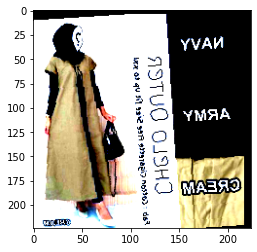

In [5]:
# First of all, dataloader output 4 dimensional tensor - [batch, channel, height, width]. 
# Matplotlib and other image processing libraries often requires [height, width, channel]
print(train_data[0][0].shape)
plt.imshow(np.transpose(train_data[10033][0].numpy(), (1, 2, 0)))

In [6]:
#np.transpose(img_data[105391][0].numpy(), (1, 2, 0))

In [7]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [8]:
train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])


In [9]:
# overwrite the validation transforms, 
# making sure to do a deepcopy to stop this also changing the training data transforms.
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 94852
Number of validation examples: 10540
Number of testing examples: 12192


In [11]:
BATCH_SIZE = 80

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE, num_workers = 2)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE, num_workers = 2)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE, num_workers = 2)

## LOAD PRETRAINED MODEL

In [17]:
pretrained_model = models.resnext101_32x8d(pretrained = True)
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [18]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = 42    #42 classes for this task

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc

In [41]:
model = pretrained_model

In [46]:
# set layers to be fine-tuned
for ii, param in model.named_parameters():
    if 'layer4' in ii:
        param.requires_grad = True
    elif 'fc' in ii:
        param.requires_grad = True

In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 28,831,786 trainable parameters


In [28]:
#USE label smoothing for criterion
 
class LabelSmoothing(nn.Module):
 
    def __init__(self, e=0.1, reduction='mean'):
        super().__init__()
 
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.e = e
        self.reduction = reduction
    
    def _one_hot(self, labels, classes, value=1):
        """
            Convert labels to one hot vectors
        
        Args:
            labels: torch tensor in format [label1, label2, label3, ...]
            classes: int, number of classes
            value: label value in one hot vector, default to 1
        
        Returns:
            return one hot format labels in shape [batchsize, classes]
        """
 
        one_hot = torch.zeros(labels.size(0), classes)
 
        #labels and value_added  size must match
        labels = labels.view(labels.size(0), -1)
        value_added = torch.Tensor(labels.size(0), 1).fill_(value)
 
        value_added = value_added.to(labels.device)
        one_hot = one_hot.to(labels.device)
 
        one_hot.scatter_add_(1, labels, value_added)
 
        return one_hot
 
    def _smooth_label(self, target, length, smooth_factor):
        """convert targets to one-hot format, and smooth
        them.
        Args:
            target: target in form with [label1, label2, label_batchsize]
            length: length of one-hot format(number of classes)
            smooth_factor: smooth factor for label smooth
        
        Returns:
            smoothed labels in one hot format
        """
        one_hot = self._one_hot(target, length, value=1 - smooth_factor)
        one_hot += smooth_factor / length
 
        return one_hot.to(target.device)
 
    def forward(self, x, target):
 
        if x.size(0) != target.size(0):
            raise ValueError('Expected input batchsize ({}) to match target batch_size({})'
                    .format(x.size(0), target.size(0)))
 
        if x.dim() < 2:
            raise ValueError('Expected input tensor to have least 2 dimensions(got {})'
                    .format(x.size(0)))
 
        if x.dim() != 2:
            raise ValueError('Only 2 dimension tensor are implemented, (got {})'
                    .format(x.size()))
 
 
        smoothed_target = self._smooth_label(target, x.size(1), self.e)
        x = self.log_softmax(x)
        loss = torch.sum(- x * smoothed_target, dim=1)
 
        if self.reduction == 'none':
            return loss
        
        elif self.reduction == 'sum':
            return torch.sum(loss)
        
        elif self.reduction == 'mean':
            return torch.mean(loss)
        
        else:
            raise ValueError('unrecognized option, expect reduction to be one of none, mean, sum')


In [29]:
#optimizer = optim.Adam(model.fc.parameters(), lr=START_LR)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothing()

model = model.cuda()
criterion = criterion.cuda()

In [30]:
EPOCHS = 30

In [31]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].view(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].view(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [36]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        #x = x.to(device)
        #y = y.to(device)
        x = x.cuda()
        y = y.cuda()
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        #print('update gradient')
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [37]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.cuda()
            y = y.cuda()

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [38]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## train model

In [ ]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):    
    start_time = time.time()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model_5.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

In [ ]:
model.load_state_dict(torch.load('resnext-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

In [80]:
#examining the model
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            #x = x.to(device)
            x = x.cuda()
            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs


In [ ]:
images, labels, probs = get_predictions(model, test_iterator)

In [ ]:
#get predict label
pred_labels = torch.argmax(probs, 1)
